In [17]:
from Regression import Regression
from Franke import Franke, FrankeNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]

np.random.seed(1942)

In [2]:
x, y = np.linspace(0, 1, 201), np.linspace(0, 1, 201)
reg = Regression()
reg.generate_generic_data(x, y, FrankeNoise)

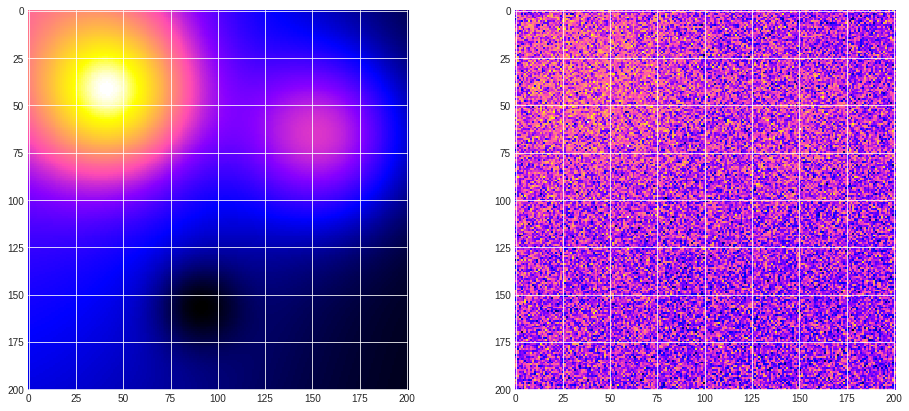

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ax1.imshow(Franke(reg.x_mesh, reg.y_mesh));
ax2.imshow(reg.f);

In [55]:
beta = reg.solveCoefficients(poly_order=5, solver="Ridge")
data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh, poly_order=5)

0.0001


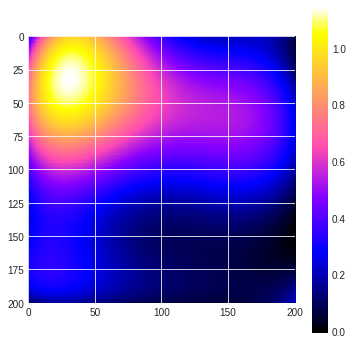

In [56]:
plt.imshow(data_pred);
plt.colorbar();

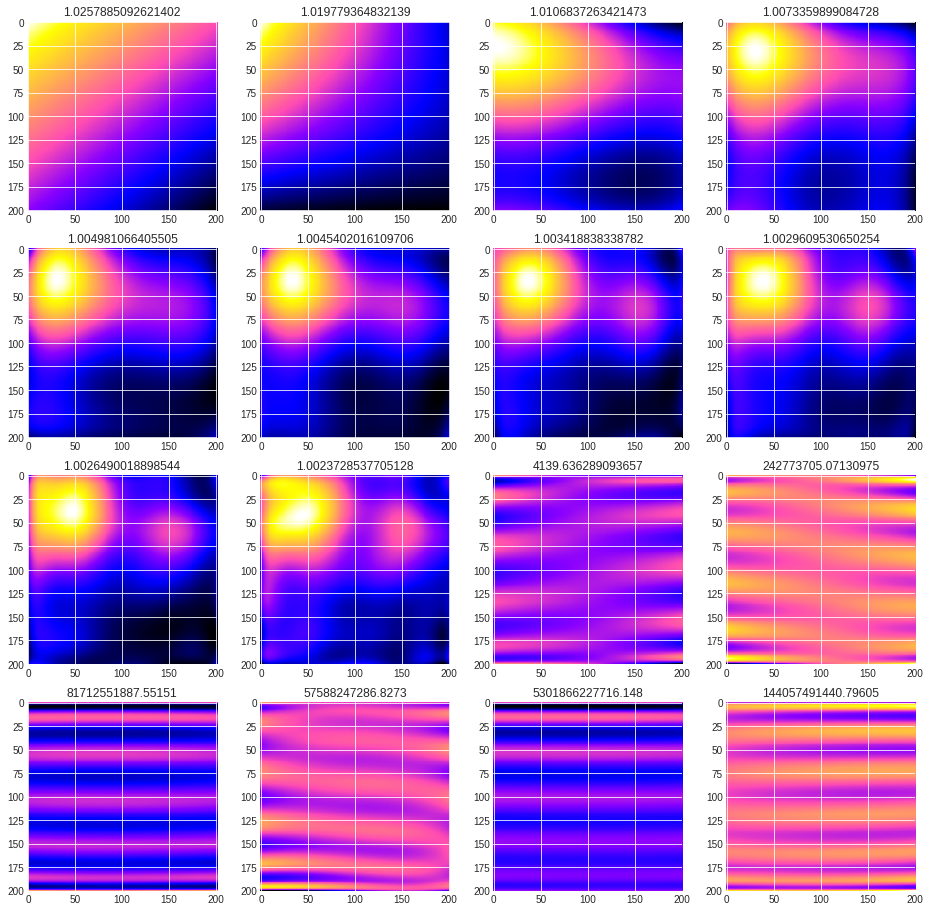

In [28]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 16
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    beta = reg.solveCoefficients(poly_order=poly_order, solver="OLS")
    data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh, poly_order=poly_order)
    ax[i//4, i%4].imshow(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, reg.f))
    err_list.append(np.sum(np.abs(reg.f - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(reg.x_mesh, reg.y_mesh) - data_pred)))    

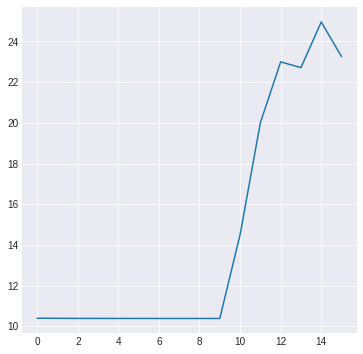

In [29]:
plt.plot(np.log(err_list));

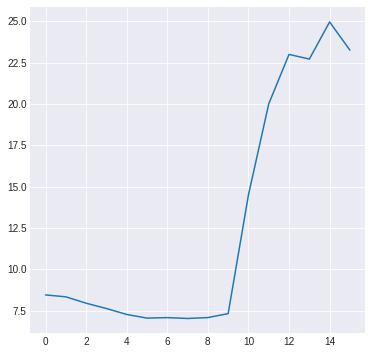

In [30]:
plt.plot(np.log(err_list_truemodel));

In [50]:
def FrankeTaylor(x, y):
    return y**5*(-0.000453698*np.exp(x*(31.5 - 20.25*x)) - 12.4866*np.exp((9 - 20.25*x)*x) - 2.80913e-21*np.exp(9*(8 - 9*x)*x) \
                - 0.0032719*np.exp((-1.65306*x - 0.367347)*x)) + y**4*(-0.0000646294*np.exp(x*(31.5 - 20.25*x)) \
                - 34.685*np.exp((9 - 20.25*x)*x) - 1.16377e-22*np.exp(9*(8 - 9*x)*x) + 0.0181772*np.exp((-1.65306*x - 0.367347)*x)) \
                + y**3*(0.000034469*np.exp(x*(31.5 - 20.25*x)) - 6.16621*np.exp((9 - 20.25*x)*x) - 3.8137e-24*np.exp(9*(8 - 9*x)*x) \
                - 0.0807876*np.exp((-1.65306*x - 0.367347)*x)) + y**2*(0.0000178728*np.exp(x*(31.5 - 20.25*x)) \
                + 2.0554*np.exp((9 - 20.25*x)*x) - 9.2714e-26*np.exp(9*(8 - 9*x)*x) + 0.269292*np.exp((-1.65306*x - 0.367347)*x)) \
                + y*(3.40435e-6*np.exp(x*(31.5 - 20.25*x)) + 0.913513*np.exp((9 - 20.25*x)*x) - 1.48682e-27*np.exp(9*(8 - 9*x)*x) \
                - 0.598427*np.exp((-1.65306*x - 0.367347)*x)) + 2.52174e-7*np.exp(x*(31.5 - 20.25*x)) + 0.101501*np.exp((9 - 20.25*x)*x) \
                - 1.18002e-29*np.exp(9*(8 - 9*x)*x) + 0.664919*np.exp((-1.65306*x - 0.367347)*x)

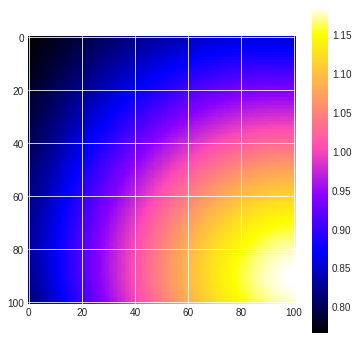

In [68]:
x, y = np.linspace(0, 0.2, 101), np.linspace(0, 0.2, 101)
x_mesh, y_mesh = np.meshgrid(x, y)
plt.imshow(FrankeTaylor(x_mesh, y_mesh));
plt.colorbar();

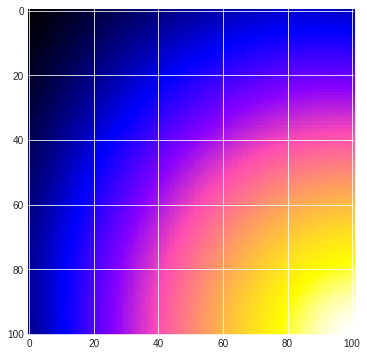

In [69]:
plt.imshow(Franke(x_mesh, y_mesh))